# Driving on a Mobius Strip

AutomotiveDrivingModels is templated to efficiently run different types of simulations.
Entities are parameterized by their:

- *S* state, which changes over time
- *D* defintion, which does not change over time
- *I* id, typically an `Int`, which uniquely identifies that entity.

In addition to these types, the actions, environment and the driver models can also be parameterized.

This notebook demonstrates a longitudinal driving simulation where cars drive on a single straight lane that loops back on itself.
The types are:

- *S* - `State1D`, containing the position and speed
- *D* - `VehicleDef`, containing length, width, and class
- *I* - `Int`

We use a `StraightRoadway` as our environment and `LaneFollowingDriver`s that produce `LaneFollowingAccel`s.


In [1]:
import Pkg

In [2]:
if !haskey(Pkg.installed(), "AutomotiveDrivingModels")
    jenv = joinpath(dirname(@__FILE__()), "..") # this assumes the notebook is in the same dir
    # as the Project.toml file, which should be in top level dir of the project. 
    # Change accordingly if this is not the case.
    Pkg.activate(jenv)
end

"/home/philippew/_phw/AutomotiveDrivingModels.jl/Project.toml"

In [3]:
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
  Updating registry at `~/.julia/registries/JuliaPOMDP`
  Updating git-repo `https://github.com/JuliaPOMDP/Registry`


In [4]:
if !haskey(Pkg.installed(), "AutoViz")
    jenv = joinpath(dirname(@__FILE__()), "../../AutoViz.jl") # this assumes the notebook is in the same dir
    # as the Project.toml file, which should be in top level dir of the project. 
    # Change accordingly if this is not the case.
    Pkg.activate(jenv)
end

"/home/philippew/_phw/AutoViz.jl/Project.toml"

In [ ]:
Pkg.instantiate()

In [5]:
using AutomotiveDrivingModels
using AutoViz

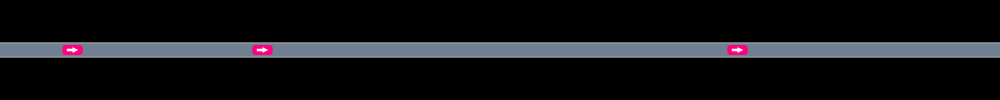

In [6]:
road_length = 200.0 # [meters]
roadway = StraightRoadway(road_length)

scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))
push!(scene, Entity(State1D(150.0, 6.0), VehicleDef(), 3))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
render(scene, roadway, cam=cam, canvas_height=100)

We can add an overlay that displays the car id for convenience:

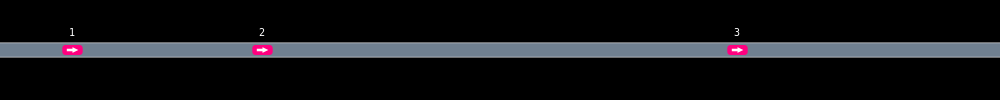

In [7]:
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)

Or we can create a new `SceneOverlay` which does this for us:

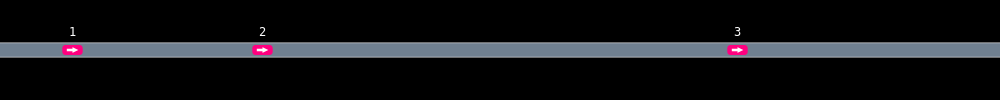

In [8]:
using Parameters
@with_kw struct CarIDOverlay <: SceneOverlay
    textparams::TextParams=TextParams()
end
function AutoViz.render!(rendermodel::RenderModel, overlay::CarIDOverlay, scene::Scene1D, roadway::StraightRoadway)
    for veh in scene
        x = veh.state.s - 0.7
        y = 3.0
        text = string(veh.id)
        add_instruction!(rendermodel, render_text, (text, x, y, overlay.textparams.size, overlay.textparams.color), incameraframe=true)
    end
    return rendermodel
end

render(scene, roadway, [CarIDOverlay()], cam=cam, canvas_height=100)

To run a simulation we need driving models that produce actions.
For this we will use `LaneFollowingDriver`s that produce `LaneFollowingAccel`s.
We will give each car a different model, as a demonstration.

In [9]:
models = Dict{Int, LaneFollowingDriver}()
models[1] = StaticLaneFollowingDriver(0.0) # always produce zero acceleration
models[2] = IntelligentDriverModel(v_des=12.0) # default IDM with a desired speed of 12 m/s
models[3] = PrincetonDriver(v_des = 10.0) # default Princeton driver with a desired speed of 10m/s

PrincetonDriver(NaN, NaN, 1.0, 10.0)

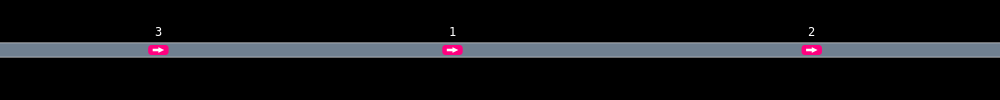

In [10]:
nticks = 100
timestep = 0.1
rec = QueueRecord(Vehicle1D, nticks+1, timestep)
simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)
render(rec[0], roadway, [CarIDOverlay()], cam=cam, canvas_height=100)

We can use Interact to inspect the simulation.

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/a3b0c039cedce0c2b7061dc0423dd13678f42181-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/a3b0c039cedce0c2b7061dc0423dd13678f42181-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:frame_index=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64}("ob_02", 0, Any[SyncCallback(Scope("knockout-component-881fe53d-223d-4cc3-8fc6-843cbe36ac60", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["frame_index"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>101,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64}(#= circular reference @-6 =#), nothing),"value"=>(Observable{Int64}("ob_01", 51, Any[SyncCallback(Scope(#= circular reference @-6 =#), SyncCallback(Scope(#= circular reference @-7 =#), ##40#42{Scope,String}(Scope(#= circular reference @-8 =#), "value"))), #g#15{##16#17{##8#10,Observable{Any}},Tuple{Observable{Int64}}}(##16#17{##8#10,Observable{Any}}(##8#10(), Observable{Any}("ob_03", CairoSurfaceBase{UInt32}(Ptr{Nothing} @0x000000000541c500, 1000.0, 100.0), Any[])), (Observable{Int64}(#= circular reference @-4 =#),))]), nothing)), Set(String[]), nothing, Any["knockout"=>"/home/philippew/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/philippew/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/philippew/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/home/philippew/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/home/philippew/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":51}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-881fe53d-223d-4cc3-8fc6-843cbe36ac60\",\"id\":\"ob_02\",\"type\":\"observable\"},val)) : un
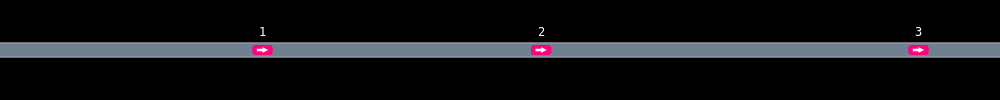
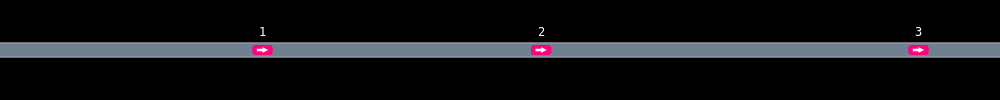

In [11]:
using Interact
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, [CarIDOverlay()], cam=cam, canvas_height=100)
end